# Exploring econdata 

In [1]:
import uproot
import awkward as ak
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns

import matplotlib.pylab as pylab
params = {'legend.fontsize': 'medium',
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'large',
         'ytick.labelsize':'medium'}
pylab.rcParams.update(params)

## 1. Load data set from ntuple

In [2]:
fname = "../data/econdata_Dec22_100evt.root"
ev_dict = uproot.open(fname)["FloatingpointAutoEncoderStrideDummyHistomaxGenmatchGenclustersntuple/HGCalTriggerNtuple"]

In [3]:
ev_dict.show()

name                 | typename                 | interpretation                
---------------------+--------------------------+-------------------------------
run                  | int32_t                  | AsDtype('>i4')
event                | int32_t                  | AsDtype('>i4')
lumi                 | int32_t                  | AsDtype('>i4')
gen_n                | int32_t                  | AsDtype('>i4')
gen_PUNumInt         | int32_t                  | AsDtype('>i4')
gen_TrueNumInt       | float                    | AsDtype('>f4')
vtx_x                | float                    | AsDtype('>f4')
vtx_y                | float                    | AsDtype('>f4')
vtx_z                | float                    | AsDtype('>f4')
gen_eta              | std::vector<float>       | AsJagged(AsDtype('>f4'), he...
gen_phi              | std::vector<float>       | AsJagged(AsDtype('>f4'), he...
gen_pt               | std::vector<float>       | AsJagged(AsDtype('>f4'), he...
gen_energy

In [4]:
arrays_toread = [
    "econ_index","econ_data",
    "econ_subdet","econ_zside","econ_layer","econ_waferu","econ_waferv","econ_wafertype",
    "tc_simenergy",
    "tc_subdet","tc_zside","tc_layer","tc_waferu","tc_waferv","tc_wafertype",
    "gen_pt","gen_energy","gen_eta","gen_phi",
    "genpart_pt","genpart_energy","econ_id"
]
events = ev_dict.arrays(arrays_toread)

#Separate the data sets
econ = ak.zip({
    "index": events['econ_index'],
    "id":events['econ_id'],
    "data": events["econ_data"],
    "subdet": events["econ_subdet"],
    "zside": events["econ_zside"],
    "layer": events["econ_layer"],
    "waferu": events["econ_waferu"],
    "waferv": events["econ_waferv"],
})

tc = ak.zip({
    "simenergy": events["tc_simenergy"],
    "subdet": events["tc_subdet"],
    "zside": events["tc_zside"],
    "layer": events["tc_layer"],
    "waferu": events["tc_waferu"],
    "waferv": events["tc_waferv"],
})

gen = ak.zip({
    "pt": events["gen_pt"],
    "energy": events["gen_energy"],
    "eta": events["gen_eta"],
    "phi": events["gen_phi"],
})

In [5]:
# find wafers that we want to save
# the problem is that the number of wafers from trigger cells: trigger cells/48 
# is not the same as the number of wafers from econ data: econ_data/16
df_tc = ak.to_pandas(tc)
df_econ = ak.to_pandas(econ)
df_gen = ak.to_pandas(gen)

In [6]:
df_tc

simenergy  subdet  zside  layer  waferu  waferv
entry subentry                                                 
0     0               0.0       2      1     40      -2      -4
      1               0.0       2     -1     35      -5       0
      2               0.0       2      1     35      -6      -5
      3               0.0       2      1     35      -6      -5
      4               0.0       2      1     32       7       2
...                   ...     ...    ...    ...     ...     ...
99    4738            0.0       1     -1      1       1      -2
      4739            0.0       1     -1      1       1      -2
      4740            0.0       1      1     25       3       3
      4741            0.0       1      1     25       3       3
      4742            0.0       1      1     25       3       3

[413236 rows x 6 columns]

In [7]:
df_simtotal = df_tc.groupby(['entry','subdet','zside','layer','waferu','waferv'])["simenergy"].sum()

#with pd.option_context('display.max_rows', None,
#                       'display.max_columns', None,
#                       'display.precision', 3,
#                       ):
#    print(df_simtotal)
#print(df_simtotal)

## 2. Process the econ data set

In [8]:
df_econ

df_econ.reset_index(inplace=True)
df_econ.set_index(['entry','subdet','zside','layer','waferu','waferv'],inplace=True)

df_econ['simenergy'] = df_simtotal

df_econ.drop(columns='subentry',inplace=True)

In [205]:
df_econ_wsimenergy = df_econ[df_econ.simenergy > 0]

In [206]:
df_econ_wsimenergy['layernum'] = df_econ_wsimenergy.index.get_level_values('layer') 

/n/home00/emoreno/miniconda3/envs/ERegress/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [11]:
df_econ_wsimenergy

index          id  data  simenergy  \
entry subdet zside layer waferu waferv                                       
0     2      1     30    1      4           0  3020456192   320   0.639610   
                                4           1  3020456192     0   0.639610   
                                4           2  3020456192     0   0.639610   
                                4           3  3020456192   320   0.639610   
                                4           4  3020456192   384   0.639610   
...                                       ...         ...   ...        ...   
99    1      1     21    4      3          11  2991875072    64   0.055536   
                                3          12  2991875072   448   0.055536   
                                3          13  2991875072   448   0.055536   
                                3          14  2991875072   448   0.055536   
                                3          15  2991875072   256   0.055536   

                                        layernum  
entry subdet zside layer waferu waferv            
0     2      1     30    1      4             30  
                                4             30  
                                4             30  
                                4             30  
                                4             30  
...                                          ...  
99    1      1     21    4      3             21  
                                3             21  
                                3             21  
                                3             21  
                                3             21  

[151200 rows x 5 columns]

In [13]:
df_econ_wsimenergy[['layer','id']]

layer          id
entry subdet zside layer waferu waferv                   
0     2      1     30    1      4          30  3020456192
                                4          30  3020456192
                                4          30  3020456192
                                4          30  3020456192
                                4          30  3020456192
...                                       ...         ...
99    1      1     21    4      3          21  2991875072
                                3          21  2991875072
                                3          21  2991875072
                                3          21  2991875072
                                3          21  2991875072

[151200 rows x 2 columns]

In [12]:
# Plot index versus layer
plt.scatter(df_econ_wsimenergy[['layer']],df_econd_wsimenergy[['id']])
plt.xlabel('Layer')
plt.ylabel("Wafer ID")

KeyError: "None of [Index(['layer'], dtype='object')] are in the [columns]"

In [218]:
df_econ_wsimenergy[['layernum','id']].iloc[:33]

layernum          id
entry subdet zside layer waferu waferv                      
0     2      1     30    1      4             30  3020456192
                                4             30  3020456192
                                4             30  3020456192
                                4             30  3020456192
                                4             30  3020456192
                                4             30  3020456192
                                4             30  3020456192
                                4             30  3020456192
                                4             30  3020456192
                                4             30  3020456192
                                4             30  3020456192
                                4             30  3020456192
                                4             30  3020456192
                                4             30  3020456192
                                4             30  3020456192
                                4             30  3020456192
                   29    0      2             29  3020177408
                                2             29  3020177408
                                2             29  3020177408
                                2             29  3020177408
                                2             29  3020177408
                                2             29  3020177408
                                2             29  3020177408
                                2             29  3020177408
                                2             29  3020177408
                                2             29  3020177408
                                2             29  3020177408
                                2             29  3020177408
                                2             29  3020177408
                                2             29  3020177408
                                2             29  3020177408
                                2             29  3020177408
                   30    2      4             30  3020456448

In [ ]:
df_econ_wsimenergy_summed = df_econ_wsimenergy[['id', 'layernum']]

x = df_econ_wsimenergy_summed.values[:,0]
y = df_econ_wsimenergy_summed.values[:,1]

print(len(x)/100)
print(max(x)-min(x))

plt.figure()
plt.hist2d(x, y, bins=(55877632, 50), cmap=plt.cm.jet)
plt.colorbar()
plt.xlabel('wafer ID')
plt.ylabel('Layer')
plt.show()

1512.0
55877632


[  1.   2.   1.  33.  45.   9.   1.   1.   7. 100.  71.   4.   1.   2.
   9.  34.   4.   1.   4.   1.   1.   1.   1.   2.   3.  38.  49.  17.
   1.   3.  17. 100.  89.   5.   1.  25.  65.   6.   6.   4.   1.   2.
   3.   1.   1.   2.   1.   4.  41.  67.  19.   2.   4.  26. 100.  96.
  11.   3.  40.  85.  15.   1.   7.   4.   2.   1.   3.   1.   1.   2.
   1.   1.   2.   1.   1.  46.  84.  25.   3.   8.   1.  42. 100.  99.
  10.   1.   1.   1.   3.  59.  92.  21.   3.   7.   9.   1.   1.   1.
   2.   1.   1.   2.   3.   1.   1.  56.  80.  20.   1.   6.  47. 100.
  98.   7.   1.   5.   1.   5.  73.  98.  34.  18.   9.   1.   4.   3.
   1.   3.   3.   1.  65.  86.  28.   9.   1.  52. 100. 100.  16.   2.
   1.  10.  81. 100.  34.   5.  20.  17.   1.   1.   2.   1.   3.   3.
   1.   1.   1.   2.   4.  65.  82.  19.   1.   4.   1.  55. 100.  99.
  10.   2.   1.   6.  87.  98.  39.   2.  18.  14.   1.   3.   2.   1.
   1.   1.   1.   4.  54.  84.  22.   1.   4.  50. 100.  99.  15.   2.
   3. 

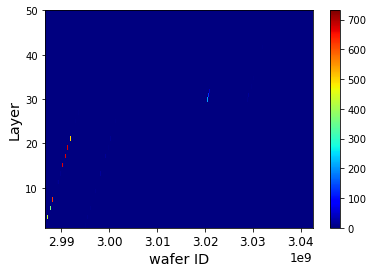

In [181]:
#indices = df_econ_wsimenergy_summed['index'].index.to_numpy()
#values = df_econ_wsimenergy_summed['index'].values

print(values/16)
#x = []
#y = []


for i in range(len(indices)): 
    for j in range(int(values[i]/16)): 
        
        x.append(indices[i][0])
        y.append(indices[i][1])

        
plt.figure()
plt.hist2d(x, y, bins=[573, 50], cmap=plt.cm.jet)
plt.colorbar()
plt.xlabel('wafer ID')
plt.ylabel('Layer')
plt.show()

[Text(0, 0, ''),
 Text(1, 0, ''),
 Text(2, 0, ''),
 Text(3, 0, ''),
 Text(4, 0, ''),
 Text(5, 0, ''),
 Text(6, 0, ''),
 Text(7, 0, ''),
 Text(8, 0, ''),
 Text(9, 0, ''),
 Text(10, 0, ''),
 Text(11, 0, ''),
 Text(12, 0, ''),
 Text(13, 0, ''),
 Text(14, 0, ''),
 Text(15, 0, ''),
 Text(16, 0, ''),
 Text(17, 0, ''),
 Text(18, 0, ''),
 Text(19, 0, ''),
 Text(20, 0, ''),
 Text(21, 0, ''),
 Text(22, 0, ''),
 Text(23, 0, ''),
 Text(24, 0, ''),
 Text(25, 0, ''),
 Text(26, 0, ''),
 Text(27, 0, ''),
 Text(28, 0, ''),
 Text(29, 0, ''),
 Text(30, 0, ''),
 Text(31, 0, ''),
 Text(32, 0, ''),
 Text(33, 0, ''),
 Text(34, 0, ''),
 Text(35, 0, ''),
 Text(36, 0, ''),
 Text(37, 0, ''),
 Text(38, 0, ''),
 Text(39, 0, ''),
 Text(40, 0, ''),
 Text(41, 0, ''),
 Text(42, 0, ''),
 Text(43, 0, ''),
 Text(44, 0, ''),
 Text(45, 0, ''),
 Text(46, 0, ''),
 Text(47, 0, ''),
 Text(48, 0, ''),
 Text(49, 0, ''),
 Text(50, 0, ''),
 Text(51, 0, ''),
 Text(52, 0, ''),
 Text(53, 0, ''),
 Text(54, 0, ''),
 Text(55, 0, ''),
 T

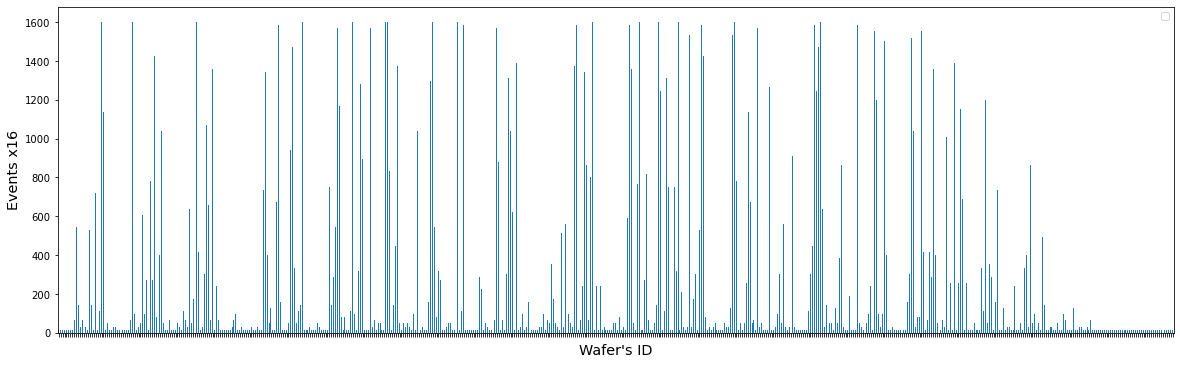

In [83]:
from matplotlib.pyplot import figure

df_econ_wsimenergy[['index','id', 'layernum']].groupby(['id', 'layernum']).count().sort_values(['layernum']).plot(kind='bar', figsize = (20,6))
plt.legend('')
plt.xlabel("Wafer's ID")
plt.ylabel("Events x16")

ax = plt.gca()
ax.axes.xaxis.set_ticklabels([])

In [96]:
df_econ_wsimenergy[['id', 'layernum']]

id  layernum
entry subdet zside layer waferu waferv                      
0     2      1     30    1      4       3020456192        30
                                4       3020456192        30
                                4       3020456192        30
                                4       3020456192        30
                                4       3020456192        30
...                                            ...       ...
99    1      1     21    4      3       2991875072        21
                                3       2991875072        21
                                3       2991875072        21
                                3       2991875072        21
                                3       2991875072        21

[151200 rows x 2 columns]

In [27]:
df_econ_wsimenergy = df_econ_wsimenergy.rename(columns={"index": "econ_index", "data": "econ_data", "simenergy": "wafer_energy"})

In [28]:
df_econ_wsimenergy[df_econ_wsimenergy.econ_index == 0]

econ_index  econ_data  wafer_energy
entry subdet zside layer waferu waferv                                     
0     2      1     30    1      4                0        704      0.639610
                   29    0      2                0        384      0.325268
                   30    2      4                0          0      0.384041
                   29    0      3                0        256      0.177588
                         1      2                0        448      0.594947
...                                            ...        ...           ...
9     1      1     1     1      3                0        384      0.314042
                   3     2      3                0       1024      0.061016
                   9     1      4                0        394      0.249215
                   3     1      2                0        832      0.058836
                   25    1      3                0        640      0.262666

[911 rows x 3 columns]

In [30]:
# Econ data: 9 -bit values from each node?
# Wafer energy: in gev

In [29]:
df_econ_wsimenergy

econ_index  econ_data  wafer_energy
entry subdet zside layer waferu waferv                                     
0     2      1     30    1      4                0        704      0.639610
                                4                1          0      0.639610
                                4                2          0      0.639610
                                4                3        704      0.639610
                                4                4        768      0.639610
...                                            ...        ...           ...
9     1      1     25    1      3               11        256      0.262666
                                3               12        320      0.262666
                                3               13        448      0.262666
                                3               14        512      0.262666
                                3               15        128      0.262666

[14576 rows x 3 columns]

In [45]:
df_econ_wsimenergy.reset_index(inplace=True)

In [46]:
df_econ_wsimenergy.set_index(['entry'],inplace=True)

In [55]:
with pd.option_context('display.max_rows', None,
                       'display.max_columns', None,
                       'display.precision', 3,
                       ):
    print(df_econ_wsimenergy.econ_data[(df_econ_wsimenergy.layer==30) & (df_econ_wsimenergy.econ_index==0)])

entry
0     704
0       0
0     192
1     768
1     576
1    1024
1     768
1     576
2     768
2     768
3     896
4    1280
4     384
4     704
4     704
5     512
5    1024
6     448
7     640
7     320
7     832
7     448
Name: econ_data, dtype: uint32


In [57]:
df_econ_wsimenergy.to_hdf('econ_data_electron_eta2.7_phi1.5_Nov22.h5', key='df', mode='w')

In [31]:
df_gen.reset_index(inplace=True)

In [32]:
df_gen.set_index('entry',inplace=True)

In [39]:
df_gen

,,pt,energy,eta,phi
entry,subentry,,,,
0,0,80.423019,599.289551,2.697059,1.492554
1,0,124.385948,927.308289,2.697515,1.498797
2,0,52.817207,391.153015,2.690819,1.491963
3,0,33.214794,246.043961,2.691075,1.491199
4,0,190.976349,1420.463135,2.695186,1.498270
5,0,35.699162,265.670898,2.695733,1.498154
6,0,145.696686,1083.321899,2.694855,1.498915
7,0,138.498276,1028.103638,2.693192,1.490191
8,0,39.580746,294.223419,2.694588,1.497054


In [ ]:
df_econ_wsimenergy['gen_energy'] = df_gen['energy']

In [ ]:
df_econ_wsimenergy